# The quintic Ornstein-Uhlenbeck model VIX iv

In [4]:
import pandas as pd
import BlackScholes as bs
import time
import numpy as np
import matplotlib.pyplot as plt
import risk_free_rates as rf
import Quintic

from scipy.optimize import least_squares as ls
from matplotlib import cm

In [2]:
data = pd.read_csv("vix_opt.csv")
vix_T = np.array(data["Exp Date"])[2:]
vix_f = np.array(data["Futures"])[2:]
IV = np.array(data.iloc[:,2:])[2:,:]/100
k = np.array([80, 90, 95, 97.5, 100, 102.5, 105, 110, 120])/100
S0 = 19.81
K = S0 * k

In [5]:
N = len(vix_T); drift = np.zeros(N);
R = np.zeros(N); Q = np.zeros(N);

for i in range(N):
    T = vix_T[i]; F = vix_f[i];
    drift[i] = -np.log(S0/F)/T
    R[i] = rf.r(T)
    Q[i] = R[i] - drift[i]

In [6]:
nr = len(vix_T); nc = len(k); n = 2000;
model_iv = np.zeros([nr, nc]); model_param = np.zeros([nr, 6]);
inp = np.array([ 0.2, 0.01, 1, 0.01, 0.02, 0.05]) #H,eps,a0,a1,a3,a5
bnds = ([-0.1, 1e-10, 0, 0, 0, 0],[0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
start_all = time.time()

for i in range(nr):
    
    start_time = time.time()
    
    T = vix_T[i]; vol = IV[i,:];
    
    r = R[i]; q = Q[i];
    
    def h(x):
        H,eps,a0,a1,a3,a5 = x
        a_k = np.array([a0, a1, a3, a5])
        P = Quintic.vix_iv(H, eps, T, a_k, K, r, q, n)
        return bs.BSImpliedVol(S0, K, T, r, q, P, 1, 1e-10)
    
    def f(x):
        return h(x) - vol
    
    res = ls(f, inp, bounds = bnds, max_nfev = 20, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
    model_param[i,:] = res.x
    model_iv[i,:] = h(res.x)
    
    print(f'Iteration: {i}\t Elapsed time: {time.time()-start_time: .0f} s')
    
print(f'\nTotal elapsed time: {time.time()-start_all: .0f} s')

print(f'\nMean percentage error: {np.mean(np.abs(model_iv-IV)/IV)*100: .4f}%')

Iteration: 0	 Elapsed time:  68 s
Iteration: 1	 Elapsed time:  69 s
Iteration: 2	 Elapsed time:  65 s
Iteration: 3	 Elapsed time:  69 s
Iteration: 4	 Elapsed time:  66 s
Iteration: 5	 Elapsed time:  68 s
Iteration: 6	 Elapsed time:  62 s
Iteration: 7	 Elapsed time:  65 s
Iteration: 8	 Elapsed time:  65 s
Iteration: 9	 Elapsed time:  67 s
Iteration: 10	 Elapsed time:  61 s
Iteration: 11	 Elapsed time:  3 s
Iteration: 12	 Elapsed time:  3 s
Iteration: 13	 Elapsed time:  3 s
Iteration: 14	 Elapsed time:  3 s
Iteration: 15	 Elapsed time:  3 s
Iteration: 16	 Elapsed time:  3 s
Iteration: 17	 Elapsed time:  3 s
Iteration: 18	 Elapsed time:  3 s

Total elapsed time:  747 s

Mean percentage error:  31.1995%


In [8]:
print(f'Mean percentage error: {np.mean(np.abs(model_iv[:11,:]-IV[:11,:])/IV[:11,:])*100: .4f}%')

Mean percentage error:  2.4955%


In [36]:
vix_T = np.append(vix_T[:2], vix_T[3:11])
nr = len(vix_T); nc = len(k);
IV = np.append(IV[:2,:], IV[3:11,:]).reshape((nr,nc))
model_iv = np.append(model_iv[:2,:], model_iv[3:11,:]).reshape((nr,nc))

In [37]:
print(f'Mean percentage error: {np.mean(np.abs(model_iv[:11,:]-IV[:11,:])/IV[:11,:])*100: .4f}%')

Mean percentage error:  1.3906%


In [3]:
model_iv = np.array(pd.read_csv("quintic_local_vix_iv.csv"))

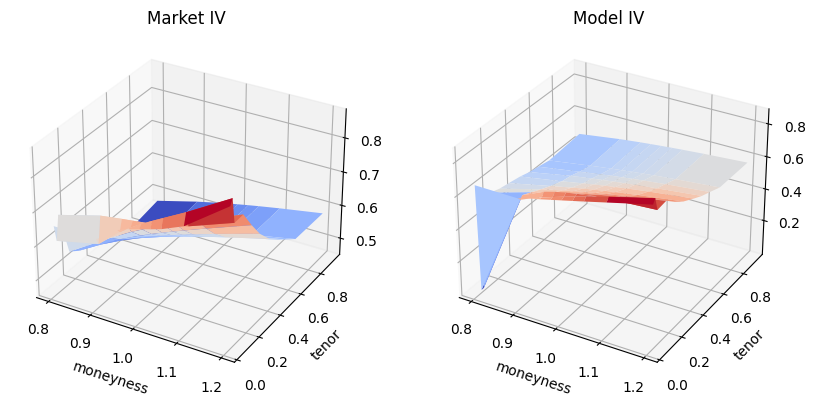

In [4]:
mesh_x, mesh_y = np.meshgrid(k, vix_T[:11])

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV[:11,:], cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, model_iv[:11,:], cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('tenor')
#ax2.set_zlabel('IV Calibrated')
ax2.set_title('Model IV')

plt.show()

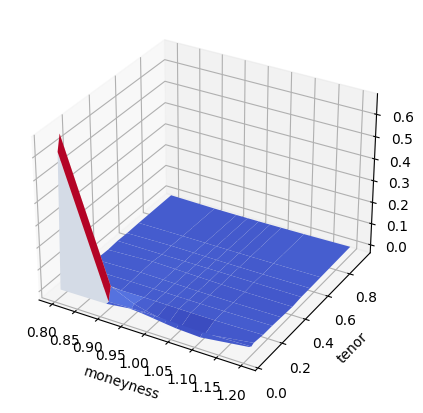

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(5)
fig.set_figwidth(10)

surf = ax.plot_surface(mesh_x, mesh_y, IV[:11,:]-model_iv[:11,:], cmap=cm.coolwarm, antialiased=True)
ax.set_xlabel('moneyness')
ax.set_ylabel('tenor')
#ax1.set_title('Market IV')

plt.show()

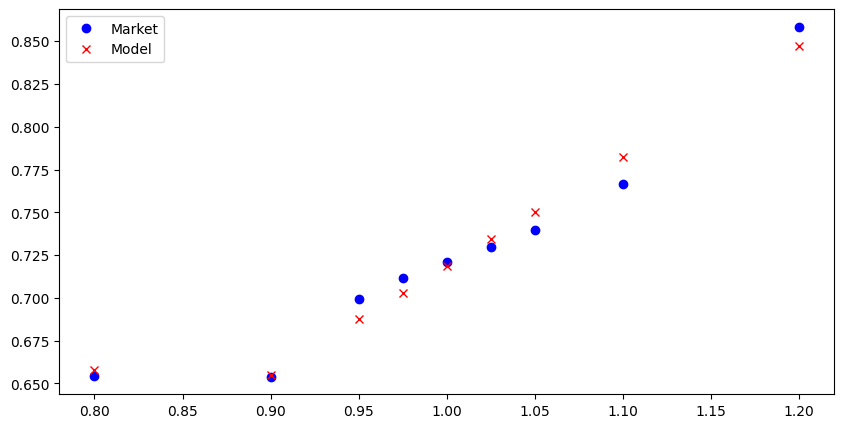

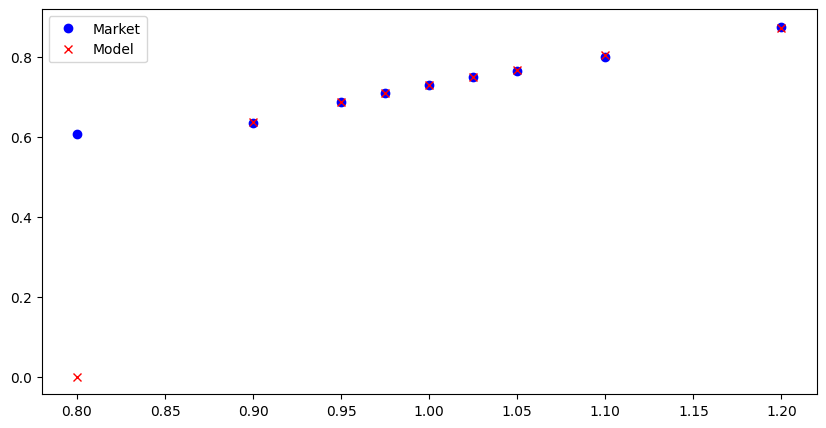

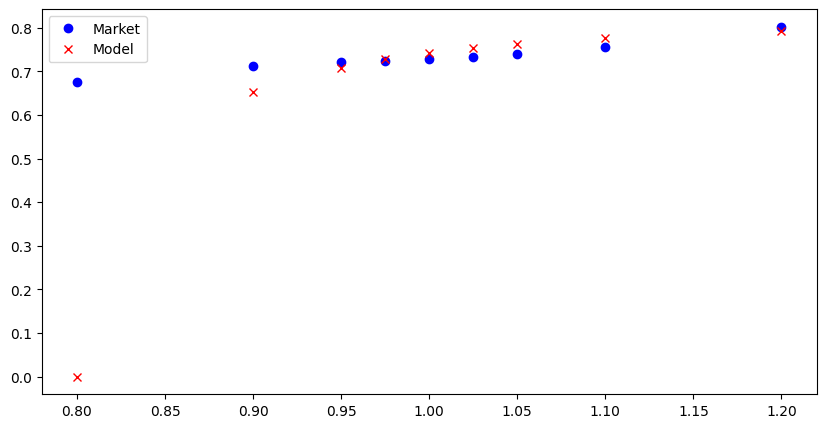

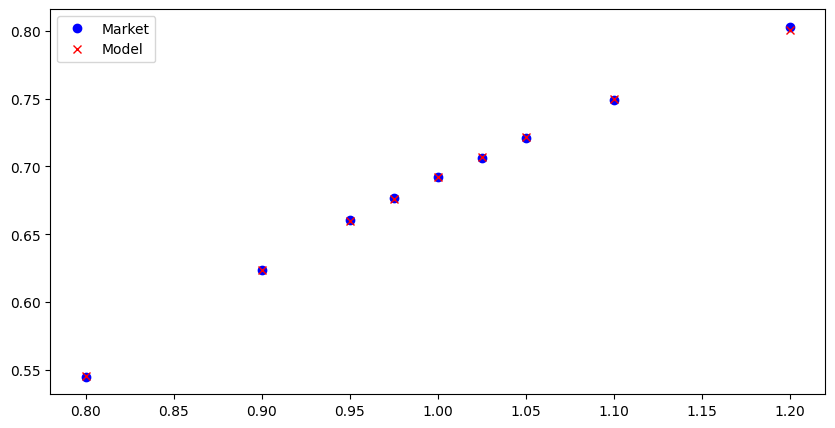

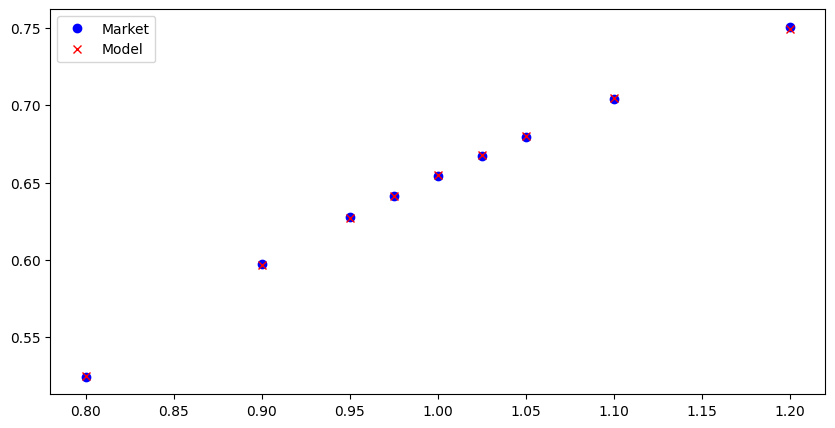

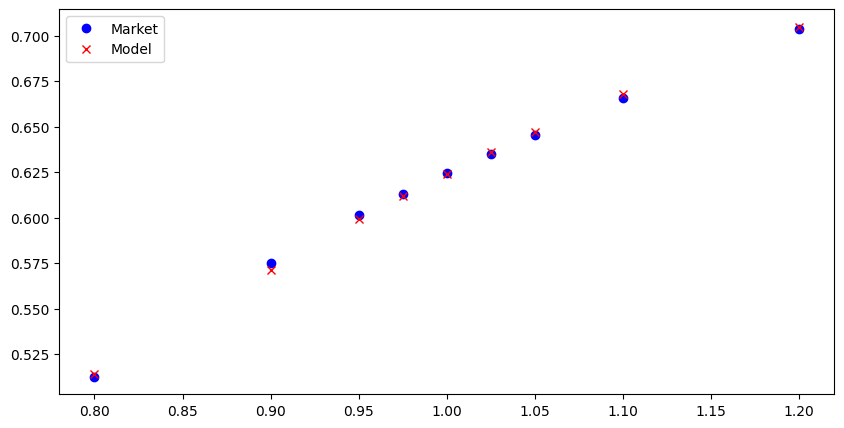

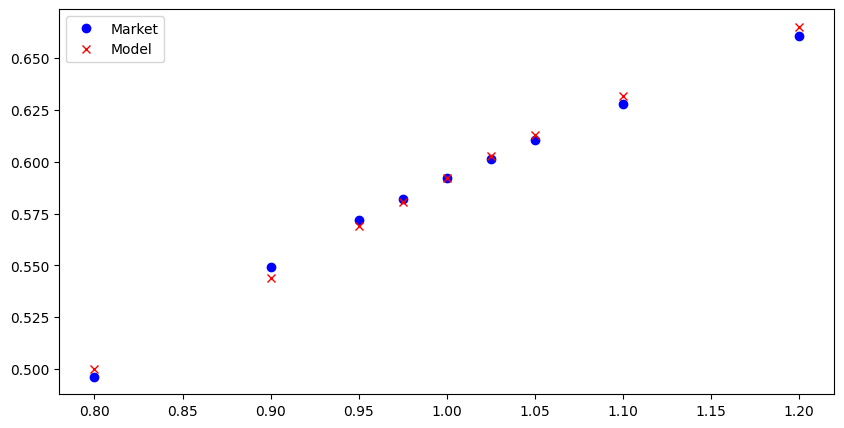

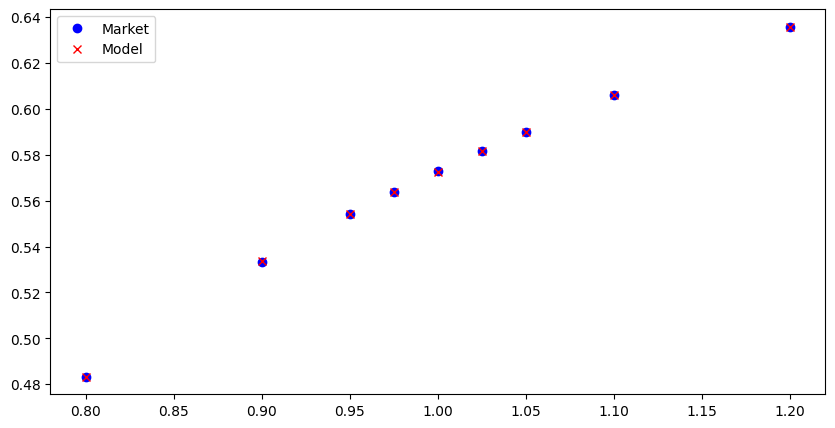

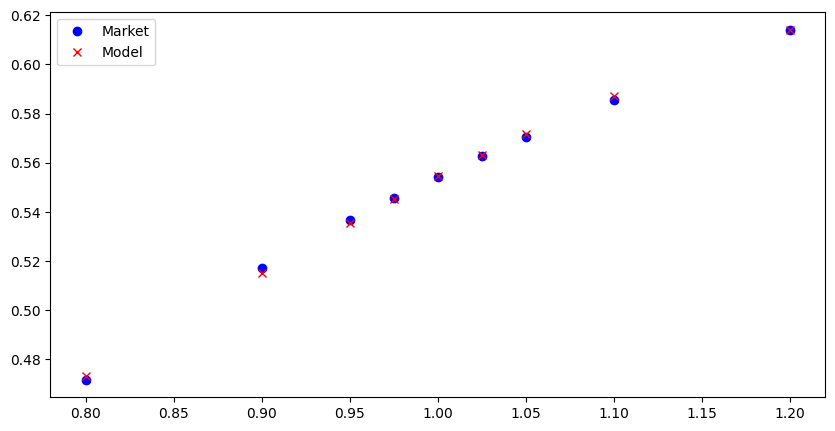

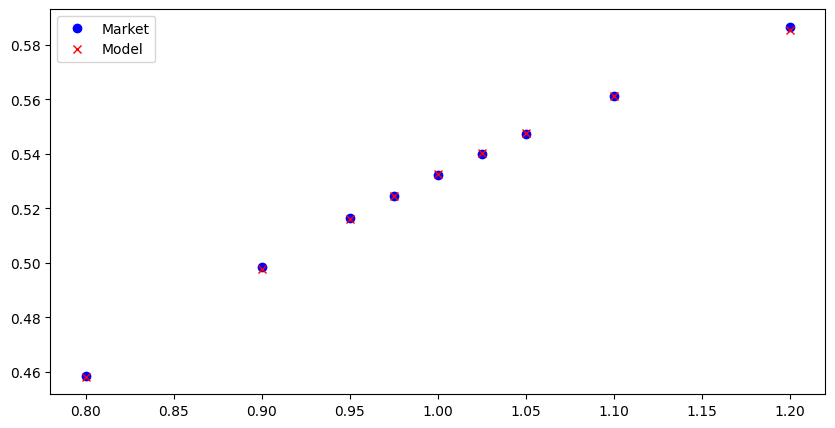

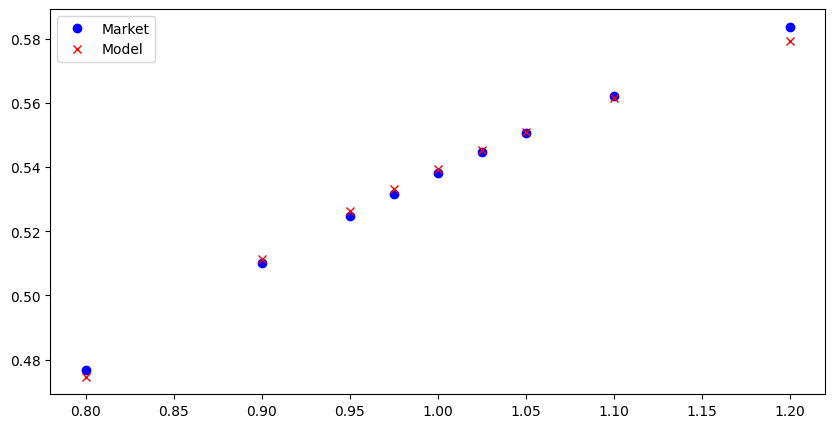

In [6]:
for i in range(11):
    fig = plt.figure(i)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.plot(k, IV[i,:],'bo')
    plt.plot(k, model_iv[i,:], 'rx')
    plt.legend(["Market","Model"])

In [9]:
df = pd.DataFrame(model_param, columns = ["H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("quintic_local_param_vix_iv.csv", index = False)
db = pd.DataFrame(model_iv)
db.to_csv("quintic_local_vix_iv.csv", index = False)